# Dembiermont Arthur

# <center>Mask R-CNN</center>
Le but de ce TP est d'apprendre le fonctionnement des algorithmes de reconnaissance d'objet.
Pour cela dans ce TP vous verrez :

- Comment fonctionne les masques
- Comment fonctionne les Bounding Box
- Affichage des résultats

In [1]:
!pip install --upgrade opencv-python
!pip install gdown

Requirement already up-to-date: opencv-python in /usr/local/lib/python3.6/dist-packages (4.5.1.48)


In [2]:
import gdown
import numpy as np
import cv2 as cv
from cv2.dnn import readNetFromTensorflow, blobFromImage
from google.colab import files
from google.colab.patches import cv2_imshow

In [3]:
gdown.download("https://drive.google.com/uc?id=1StvgNbOx-22h6A57H5NqG2GP8qbWzrs-", "LIB.tar.gz", quiet = False)
!tar zxvf LIB.tar.gz
!rm LIB.tar.gz

Downloading...
From: https://drive.google.com/uc?id=1StvgNbOx-22h6A57H5NqG2GP8qbWzrs-
To: /content/LIB.tar.gz
60.6MB [00:00, 172MB/s] 


./._colors.txt
colors.txt
./._frozen_inference_graph.pb
frozen_inference_graph.pb
./._mask_rcnn_inception_v2_coco_2018_01_28.pbtxt
mask_rcnn_inception_v2_coco_2018_01_28.pbtxt
./._mscoco_labels.names
mscoco_labels.names
./._people_walking.mp4
people_walking.mp4


***Initialisation des paramètres :***

In [4]:
# Initialize the parameters
confThreshold = 0.5  #Confidence threshold
maskThreshold = 0.3  # Mask threshold

***Récupération des labels,du graphe et des poids du modèle :***

Objectif :
  - Récupération des labels à partir du fichier mscoco_labels.names
  - Récupération des couleurs pour les bounding boxes à partir du fichier colors.txt
  - Setup du modèle
    - Le graph du réseau se trouve dans mask_rcnn_inception_v2_coco_2018_01_28.pbtxt
    - Les poifs se trouvent dans frozen_inference_graph.pb

Pour vous aidez dans le chargement du réseau, regarder les méthode suivantes :
  - cv.dnn.readNetFromTensorFlow
  - setPreferableBackend
  - setPreferableTarget



In [5]:
# Load names of classes
classesFile = "mscoco_labels.names"
classes = None
# TODO
with open(classesFile, 'rt') as f:
   classes = f.read().rstrip('\n').split('\n')


# Load the colors
colorsFile = "colors.txt"
with open(colorsFile, 'rt') as f:
    colorsStr = f.read().rstrip('\n').split('\n')
colors = []
for i in range(len(colorsStr)):
    rgb = colorsStr[i].split(' ')
    color = np.array([float(rgb[0]), float(rgb[1]), float(rgb[2])])
    colors.append(color)

# Give the textGraph and weight files for the model
# TODO
textGraph = "./mask_rcnn_inception_v2_coco_2018_01_28.pbtxt"
modelWeights = "./frozen_inference_graph.pb"

# Load the network
# TODO
net = cv.dnn.readNetFromTensorflow(modelWeights, textGraph)
net.setPreferableBackend(cv.dnn.DNN_BACKEND_OPENCV)

net.setPreferableTarget(cv.dnn.DNN_TARGET_CPU)


***Extraction des bounding boxes et des masques pour les objets détectés :***

Objectif :
  - Extraire les données des bounding boxes
  - Extraire les masques
  - Dessiner les boxes avec toutes les informations nécessaires

Les données boxes et masks sont sous les formes :
  - boxes : [0,0,nbId]
    - box : (_, classeID, score, left, top, right, bottom)
  - masks : (Number of detected object, Number of classes, (Segmentation shape))



In [6]:
# For each frame, extract the bounding box and mask for each detected object
def postprocess(frame, boxes, masks):

    # TODO : Récupération du nombre de classes et de détection
    numClasses = masks.shape[1]
    numDetections = boxes.shape[2]
     
    # TODO : Récupération des dimensions des frames
    frameH = frame.shape[0]
    frameW = frame.shape[1]

     
    # TODO : Traité toute les detections
    for i in range(numDetections):
        box = boxes[0, 0, i]
        mask = masks[i]
        score = box[2]
        if score > confThreshold:
            # TODO extraire tous les paramètres de drawBox
            classId = int(box[1])
            
            left = int(frameW * box[3])
            top = int(frameH * box[4])
            right = int(frameW * box[5])
            bottom = int(frameH * box[6])
            
            left = max(0, min(left, frameW - 1))
            top = max(0, min(top, frameH - 1))
            right = max(0, min(right, frameW - 1))
            bottom = max(0, min(bottom, frameH - 1))
            
            classMask = mask[classId]
            # Draw bounding box, colorize and show the mask on the image
            drawBox(frame, classId, score, left, top, right, bottom, classMask)

In [7]:
# Draw the predicted bounding box, colorize and show the mask on the image
def drawBox(frame, classId, conf, left, top, right, bottom, classMask):
    # Draw a bounding box.
    cv.rectangle(frame, (left, top), (right, bottom), (255, 178, 50), 3)
     
    # Print a label of class.
    label = '%.2f' % conf

    if classes:
        assert(classId < len(classes))
        label = '%s:%s' % (classes[classId], label)
     
    # Display the label at the top of the bounding box
    labelSize, baseLine = cv.getTextSize(label, cv.FONT_HERSHEY_SIMPLEX, 0.5, 1)
    top = max(top, labelSize[1])
    cv.rectangle(frame, (left, top - round(1.5*labelSize[1])), (left + round(1.5*labelSize[0]), top + baseLine), (255, 255, 255), cv.FILLED)
    cv.putText(frame, label, (left, top), cv.FONT_HERSHEY_SIMPLEX, 0.75, (0,0,0), 1)
 
    # Resize the mask, threshold, color and apply it on the image
    classMask = cv.resize(classMask, (right - left + 1, bottom - top + 1))
    mask = (classMask > maskThreshold)
    roi = frame[top:bottom+1, left:right+1][mask]
 
    color = colors[classId%len(colors)]
    # Comment the above line and uncomment the two lines below to generate different instance colors
    #colorIndex = random.randint(0, len(colors)-1)
    #color = colors[colorIndex]
 
    frame[top:bottom+1, left:right+1][mask] = ([0.3*color[0], 0.3*color[1], 0.3*color[2]] + 0.7 * roi).astype(np.uint8)
 
    # Draw the contours on the image
    mask = mask.astype(np.uint8)
    contours, hierarchy = cv.findContours(mask,cv.RETR_TREE,cv.CHAIN_APPROX_SIMPLE)
    cv.drawContours(frame[top:bottom+1, left:right+1], contours, -1, color, 3, cv.LINE_8, hierarchy, 100)

***Affichage des résultats :***

Selection du fichier d'input

Selection du fichier d'output

Regarder la fonction blobFromImage pour obtenir les blob

In [8]:
inputFile = "people_walking.mp4"
outputFile = "out_people_walking.mp4"
cap = cv.VideoCapture(inputFile)

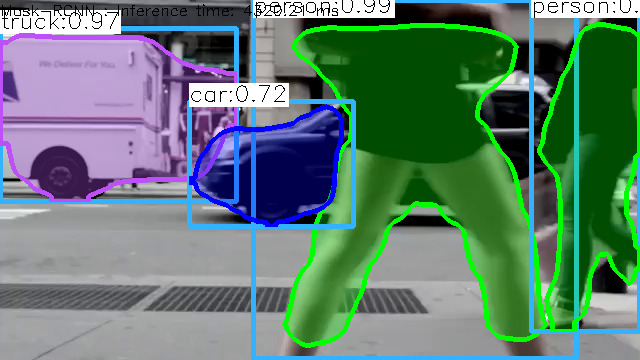

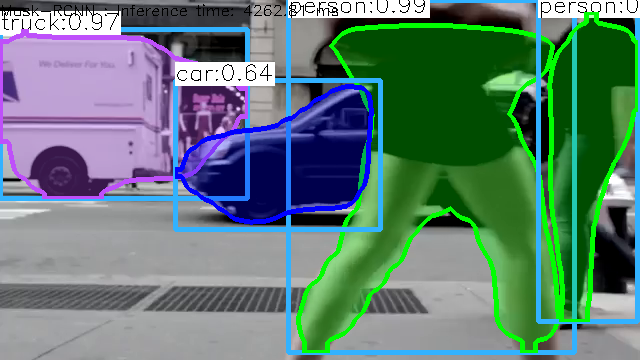

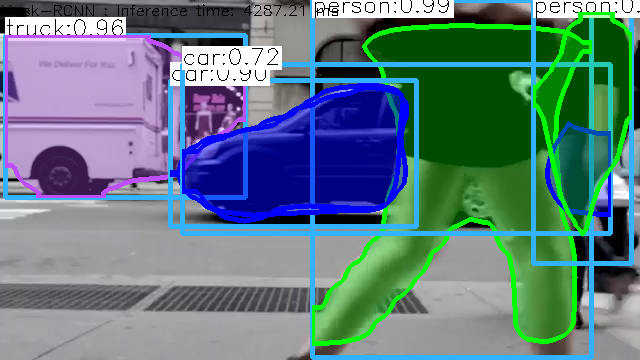

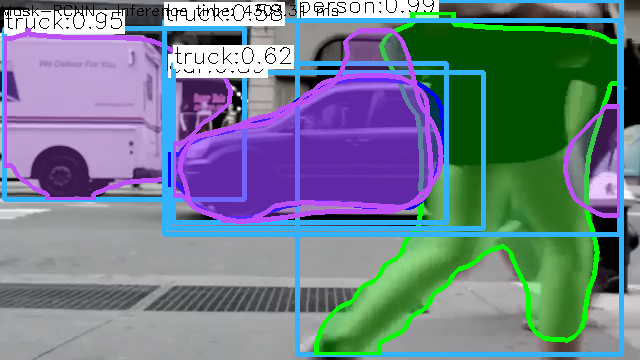

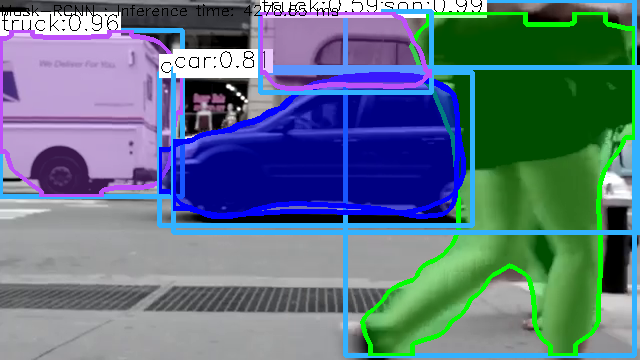

In [9]:
i = 0
while cv.waitKey(1) < 0:
     
    # Get frame from the video
    hasFrame, frame = cap.read()
     
    # Stop the program if reached end of video
    if not hasFrame:
        print("Done processing !!!")
        print("Output file is stored as ", outputFile)
        cv.waitKey(3000)
        break
 
    # Create a 4D blob from a frame.
    # TODO
    blob = cv.dnn.blobFromImage(frame, swapRB=True, crop=False)
 
    # Set the input to the network
    # TODO
    net.setInput(blob)

    # Run the forward pass to get output from the output layers
    boxes, masks = net.forward(['detection_out_final', 'detection_masks'])
 
    # Extract the bounding box and mask for each of the detected objects
    postprocess(frame, boxes, masks)
 
    # Put efficiency information.
    t, _ = net.getPerfProfile()
    label = 'Mask-RCNN : Inference time: %.2f ms' % (t * 1000.0 / cv.getTickFrequency())
    cv.putText(frame, label, (0, 15), cv.FONT_HERSHEY_SIMPLEX, 0.5, (0, 0, 0))
 
    # TODO Ecriture du fichier
    # Write the frame with the detection boxes
    # if (args.image):
    #     cv.imwrite(outputFile, frame.astype(np.uint8));
    # else:
    #     vid_writer.write(frame.astype(np.uint8))
    
    #cv.VideoWriter(outputFile,cv.VideoWriter_fourcc('M','J','P','G'), 10, (frame.shape[1],frame.shape[0]))
    if i < 5:
        i+=1
        cv2_imshow(frame)
    else:
        break